**Saida Huseyn**                                                                                              
**July, 2022**

**Capstone Project** Short term rental analysis: **What makes a super host?** Example of New York City Airbnb rentals.

- **Current Notebook**: Part 2 of 3 "Capstone_EDA_Preprocessing"
- **Next Notebook**: Part 3 of 3 "Capstone_Supervised_Classification"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy import stats
import statsmodels.api as sm
from scipy.stats import norm

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline

np.random.seed(12345)

## EDA: General Visuals, Understand the data distributions
- use cleaned data from Capstone_Data_Cleaning
- also use raw data "df" for some geo-feature analysis

In [2]:
#read cleaned saved data
%store -r data

In [3]:
#also read raw data for listings for initial EDA
df=pd.read_csv('listings.csv')

C:\Users\saida\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
categorical_columns = data.select_dtypes("object").columns
numeric_columns = data.select_dtypes("number").columns

In [5]:
categorical_columns # no object values, all cleaned

Index([], dtype='object')

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
data.shape

(37460, 50)

In [8]:
data.head(1)

,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,host_months,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Hotel room,Private room,Shared room,amenities_number,wifi,tv,hot water,air conditioning,bathtub,dedicated workspace,board games,sound system,bbq grill,refrigerator
0,0,1,1,40.75356,-73.98559,1,1.0,1.0,1.0,150.0,30,1125,1,30,60,77,334,48,0,0,4.7,4.72,4.62,4.76,4.79,4.86,4.41,0,3,166.0,0,0,1,0,0,1,0,0,0,31,1,1,1,1,1,1,0,0,0,1


Convert price in raw data df into number

In [9]:
df['price'] = df['price'].str.replace(',','')

In [10]:
df['price'] = df['price'].str.replace('$','')

C:\Users\saida\AppData\Local\Temp/ipykernel_24644/221282035.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('$','')


In [11]:
df['price'] = pd.to_numeric(df['price'],errors = 'raise')

In [12]:
df['price'].dtype

dtype('float64')

Price is numeric

---

### Geo visuals: neighbourhood, price, listings, property types

Let's first map our data to have an idea how Airbnb listings are distributed in NYC and what are the property types

C:\Users\saida\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


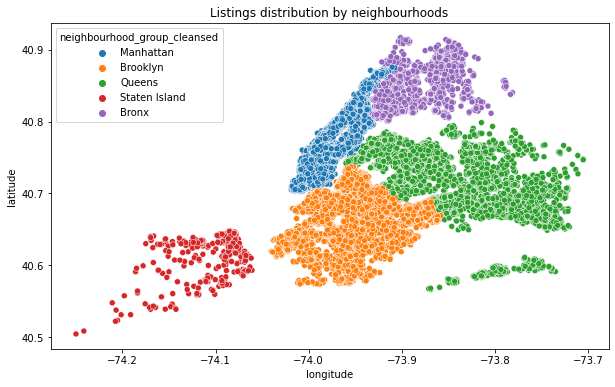

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(data.longitude,data.latitude,hue=df['neighbourhood_group_cleansed'])
plt.title('Listings distribution by neighbourhoods')
plt.ioff()

In [19]:
sub_6=data[data['price'] < 1000]

There are 5 neighbourhood groups: Manhattan, Brooklyn, Queens, Staten Island, Bronx
All have good density of listings; Manhattan leads the list with the highest number of observations in the dataset

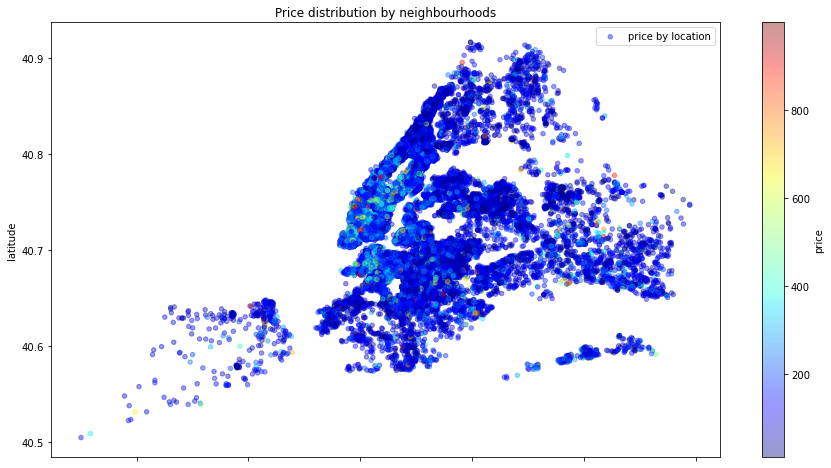

In [20]:
#let's what we can do with our given longtitude and latitude columns and prices
# Let's see the general distribution of prices over locations

#let's see how scatterplot will come out 
viz_4=sub_6.plot(kind='scatter', x='longitude', y='latitude', label='price by location', c='price',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, figsize=(15,8))
plt.title('Price distribution by neighbourhoods')
viz_4.legend()

Looks like similar prices are everywhere; however, we need statistical analysis to explore the relationsip of location to the price

C:\Users\saida\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


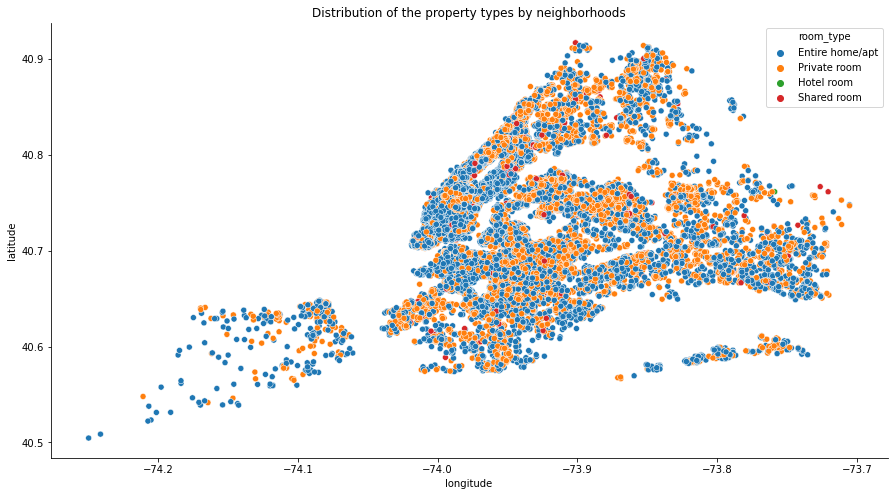

In [15]:
plt.figure(figsize=(15,8))
sns.scatterplot(data.longitude, data.latitude, hue=df['room_type'])
plt.title('Distribution of the property types by neighborhoods')
plt.ioff()
sns.despine();

**Observations**
- price and property types are similarly distributed across neighbourhoods. As those plots are not very informative in terms of statistics, let's move to more detailed analysis


### General **Heatmap** for cleaned data

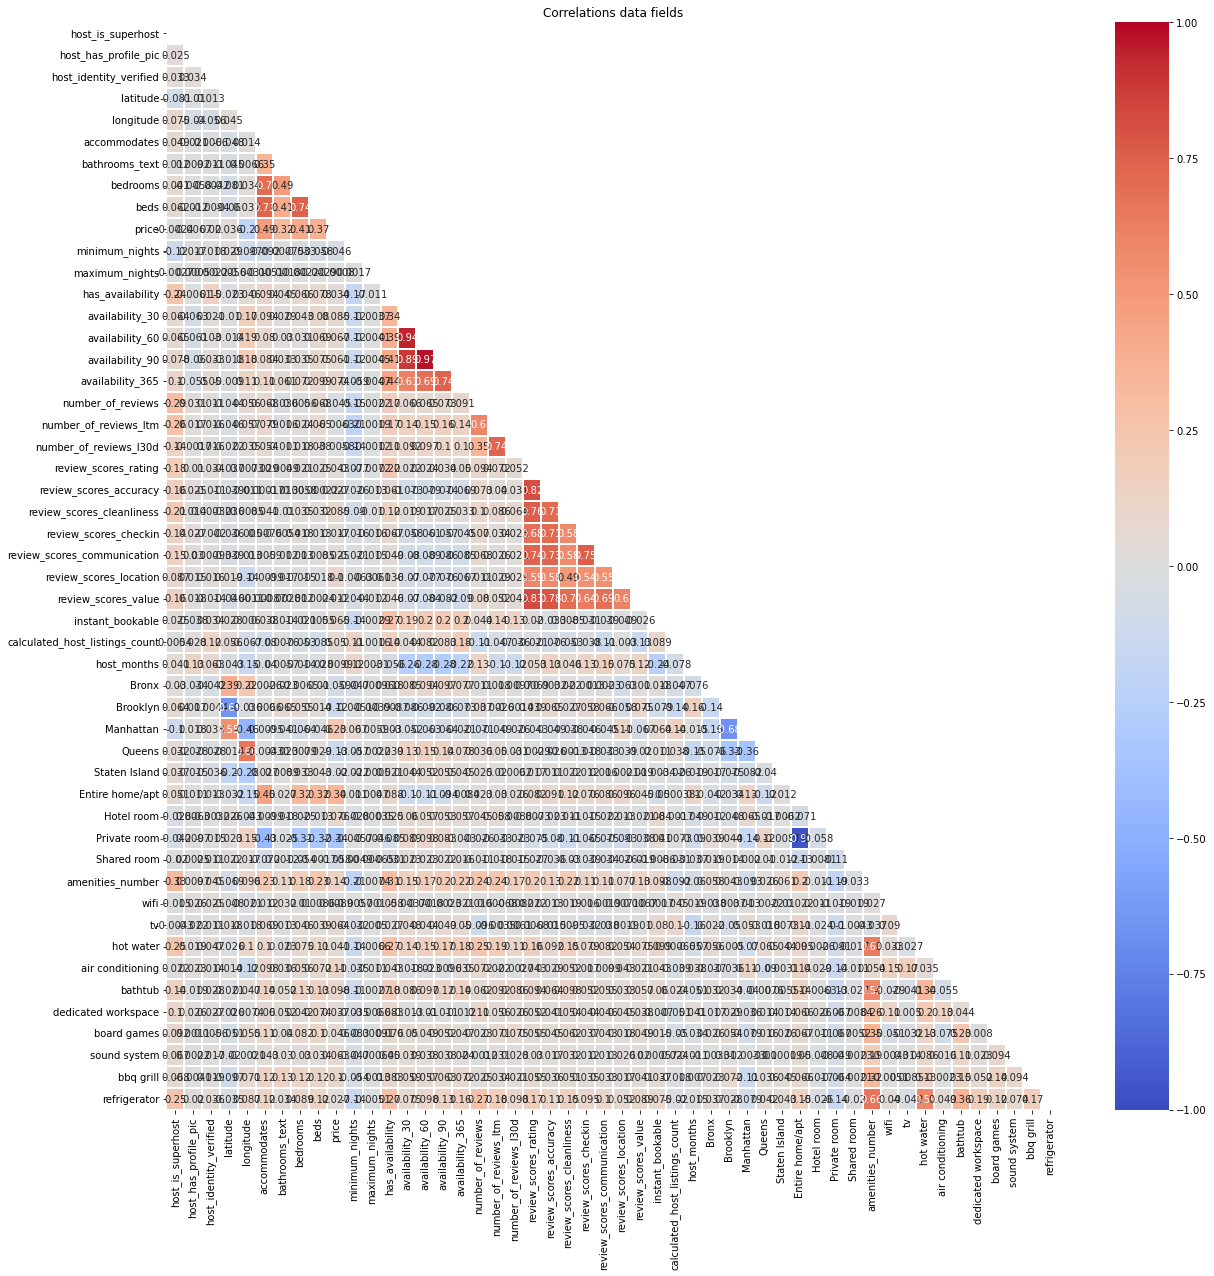

In [16]:
# correlation heatmap with the upper triangle masked
plt.figure(figsize = (20,20))
sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap="coolwarm", annot=True, mask=np.triu(data.corr()), linewidths=1.5)
plt.title("Correlations data fields")
plt.show()

In [17]:
# heatmap is not informative; too many columns
#let's look at a correlation matrix
data.corr()

,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,host_months,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Hotel room,Private room,Shared room,amenities_number,wifi,tv,hot water,air conditioning,bathtub,dedicated workspace,board games,sound system,bbq grill,refrigerator
host_is_superhost,1.000000,0.025135,0.032823,-0.080991,0.074731,0.049232,0.012395,0.040873,0.061753,-0.002381,-0.118130,-0.002701,0.240043,0.063506,0.064741,0.078109,0.101487,0.291274,0.261076,0.139193,0.183140,0.159226,0.210166,0.140058,0.147889,0.087283,0.162981,0.025152,0.005424,0.041457,0.029589,0.064365,-0.104333,0.032432,0.037265,0.050942,-0.027632,-0.042484,-0.020492,0.327361,-0.015487,-0.004289,0.245903,0.021795,0.138604,0.103032,0.091950,0.066513,0.067908,0.250768
host_has_profile_pic,0.025135,1.000000,0.034033,-0.010406,-0.040276,-0.021349,0.009245,-0.005843,-0.011968,-0.006674,0.016763,0.000503,-0.006119,-0.062595,-0.061463,-0.059847,-0.055117,0.031482,0.017160,-0.001678,0.010206,0.024891,0.013729,0.026613,0.029947,0.014546,0.017565,-0.037688,0.028018,0.125854,-0.034017,0.017483,0.018041,-0.028050,-0.014974,-0.011126,0.006260,0.009744,0.002456,0.009738,0.026326,-0.021973,0.019175,0.023314,-0.019219,0.026361,0.001092,0.002228,-0.004079,0.020222
host_identity_verified,0.032823,0.034033,1.000000,0.013279,-0.056043,0.006626,0.010595,-0.004160,-0.009389,0.020023,-0.018318,0.002184,0.145697,0.021430,0.029863,0.033057,0.049692,0.010831,0.015898,0.016149,0.033757,-0.010973,0.000320,-0.002010,0.000929,0.016119,-0.014248,0.034242,0.119578,0.063179,-0.042471,0.004435,0.037636,-0.027730,-0.035922,0.012909,-0.003210,-0.015327,0.011387,0.045070,0.025271,0.010868,0.046803,0.014405,0.028353,0.026574,0.005557,0.016961,0.019156,0.035620
latitude,-0.080991,-0.010406,0.013279,1.000000,0.045478,-0.048429,-0.044828,-0.080995,-0.060123,0.035626,0.029124,0.005646,-0.023230,-0.010106,-0.013557,-0.017704,-0.009013,-0.043806,-0.045853,-0.022012,-0.037298,-0.039104,-0.035972,-0.036250,-0.038999,0.018955,-0.045626,0.027567,0.056057,-0.042514,0.392540,-0.649731,0.546462,-0.014422,-0.195222,-0.031943,0.026400,0.023243,0.021831,-0.068622,-0.008048,0.018479,-0.025925,0.013637,-0.020658,-0.025656,-0.050586,-0.019726,-0.097037,-0.034650
longitude,0.074731,-0.040276,-0.056043,0.045478,1.000000,0.013764,0.006599,0.033961,0.037082,-0.196966,-0.097402,-0.003089,0.046157,0.170356,0.185766,0.184445,0.110599,0.056113,0.056711,0.035286,0.007277,-0.011007,0.008523,-0.005014,-0.013204,-0.137348,0.001082,0.005981,-0.067333,-0.145201,0.224110,-0.036455,-0.464799,0.657722,-0.284763,-0.145040,-0.043378,0.147244,0.016702,0.095506,-0.021031,-0.018011,0.104234,-0.120928,0.046742,0.007364,0.055160,-0.002084,0.071414,0.087079
accommodates,0.049232,-0.021349,0.006626,-0.048429,0.013764,1.000000,0.352051,0.701826,0.732297,0.486127,-0.092276,-0.005066,0.094252,0.093524,0.079784,0.084211,0.107904,0.067529,0.078860,0.053861,0.029440,0.000173,0.040916,0.007564,0.005934,-0.009894,-0.000866,0.037669,-0.079537,-0.039984,0.002628,0.006640,-0.009499,-0.004323,0.027085,0.451758,-0.009907,-0.434714,-0.071593,0.232520,0.012446,0.068877,0.100858,0.098481,0.137081,0.060326,0.108683,0.043302,0.122403,0.122554
bathrooms_text,0.012395,0.009245,0.010595,-0.044828,0.006599,0.352051,1.000000,0.489354,0.409866,0.323488,-0.000752,-0.001813,0.045484,0.029291,0.029828,0.032996,0.061487,-0.035756,-0.015750,-0.010902,0.004927,-0.012698,-0.010243,-0.005351,-0.011637,-0.016715,-0.002781,-0.014167,0.007596,0.005653,-0.022932,0.064679,-0.040749,-0.022650,0.0088

**Observations**
- Although the correlations are mostly small, there are several expected results:
- Price is correlated to accomodating capacity; beds, bathrooms, bedrooms etc. It is also related to the location and the type of the property
- Superhost has positive correlation with review_scores, availability of the property, number of amenities, negative close to zero correlation with price, and almost no correlation with locations.

---

## Price analysis

### **Neighbourhood** vs **Price** analysis

Let's see basic statistics

In [18]:
df.groupby(['neighbourhood_group_cleansed'])['price'].describe()

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group_cleansed,,,,,,,,
Bronx,1203.0,104.946800,122.036773,0.0,52.0,77.0,120.0,2000.0
Brooklyn,14367.0,134.872973,173.608221,0.0,60.0,99.0,159.0,7184.0
Manhattan,16086.0,218.186187,403.785989,0.0,96.0,149.0,226.0,10000.0
Queens,5640.0,113.591844,261.066562,10.0,50.0,76.0,125.0,10000.0
Staten Island,335.0,121.877612,122.468351,33.0,65.5,95.0,128.5,1200.0


**Observations**
- stdev is the highest for Manhattan, also the mean.
- all groups have high variance

How could we be sure that the difference in means is not due to random chance? This is why we need a test that takes into account both the difference in means, the overall variance and the individual variances of the group. That is how ANOVA f_oneway test can help us.


Before the ANOVA test, let's plot the distribution of prices by neighbourhoods to explore the relationship further

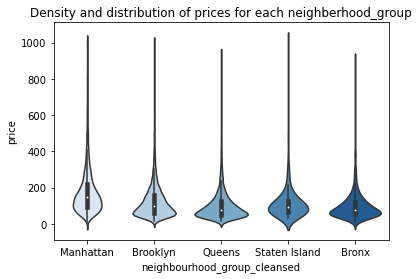

In [21]:
#creating a sub-dataframe with no extreme values / less than 1000
sub_6=data[data['price'] < 1000]
#using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(x=df['neighbourhood_group_cleansed'], y=sub_6['price'], palette="Blues")
viz_2.set_title('Density and distribution of prices for each neighberhood_group');

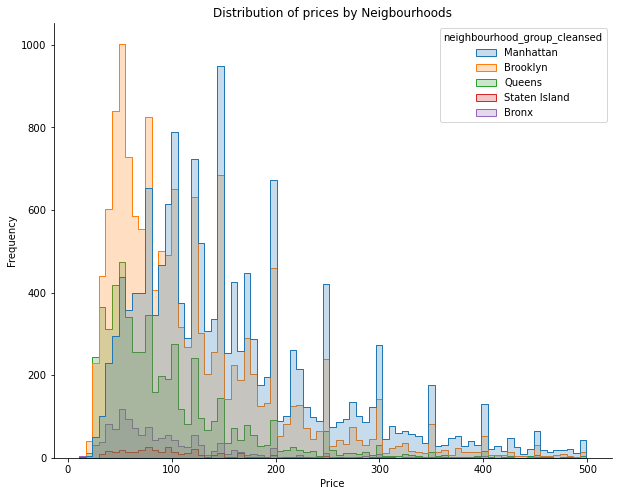

In [59]:
#creating a sub-dataframe with no extreme values / less than 1000
sub_6=data[data['price'] < 500]
#using histogram to show distribtuion of prices 
plt.figure(figsize=(10,8))
viz_2=sns.histplot(x=sub_6['price'], hue=df['neighbourhood_group_cleansed'], element="step")
viz_2.set_title('Distribution of prices by Neigbourhoods')
sns.despine()
plt.xlabel("Price")
plt.ylabel("Frequency");

**ANOVA** for neighbourhoods and the price

We can use multiclass ANOVA test to compare if any of the neighbourhoods is different from others when it comes to price.

In [37]:
anova_data = {}
neighbourhood_groups = df["neighbourhood_group_cleansed"].unique()

# slice out the price for each neighbourhood_group
for neigh in neighbourhood_groups:
    anova_data[neigh] = df.loc[df["neighbourhood_group_cleansed"] == neigh, "price"]

In [38]:
stats.f_oneway(anova_data["Manhattan"], 
               anova_data["Brooklyn"], 
               anova_data["Queens"],
               anova_data["Staten Island"],
               anova_data["Bronx"])

F_onewayResult(statistic=212.84554672427996, pvalue=6.393408704139476e-181)

With the small p-value and high statistical value, we reject the null hypothesis: there is statistically significant difference in price when choosing a neighbourhood group.

Let's see pairwise tests:

In [39]:
from statsmodels.stats import multicomp

multicomp.pairwise_tukeyhsd(df['price'], df['neighbourhood_group_cleansed']).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Bronx,Brooklyn,29.9262,0.009,5.0878,54.7645,True
Bronx,Manhattan,113.2394,0.001,88.5038,137.975,True
Bronx,Queens,8.645,0.8961,-17.6362,34.9262,False
Bronx,Staten Island,16.9308,0.8926,-34.1923,68.0539,False
Brooklyn,Manhattan,83.3132,0.001,73.8137,92.8127,True
Brooklyn,Queens,-21.2811,0.001,-34.2847,-8.2776,True
Brooklyn,Staten Island,-12.9954,0.9,-58.7333,32.7426,False
Manhattan,Queens,-104.5943,0.001,-117.4005,-91.7881,True
Manhattan,Staten Island,-96.3086,0.001,-141.9908,-50.6263,True
Queens,Staten Island,8.2858,0.9,-38.2515,54.8231,False


**Observations**
- the test shows that Manhattan is significantly different from all groups: higher prices
- Brookly is different from Queens: higher prices 

---

### **Room Type** versus **Price** analysis

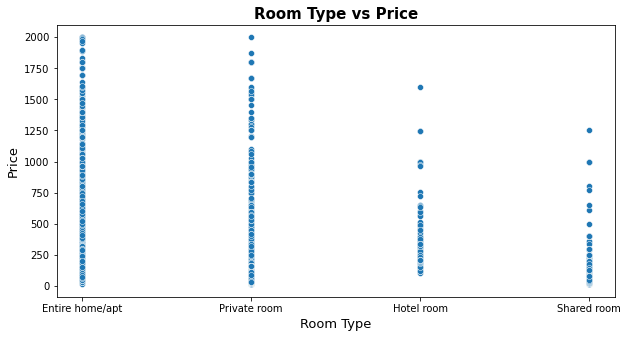

In [40]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=df['room_type'], y=data['price'])
plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type vs Price",size=15, weight='bold');

In [41]:
anova_data = {}
room_type = df["room_type"].unique()

# slice out the price for each neighbourhood_group
for room in room_type:
    anova_data[room] = df.loc[df["room_type"] == room, "price"]

In [42]:
stats.f_oneway(anova_data["Entire home/apt"], 
               anova_data["Private room"], 
               anova_data["Hotel room"],
               anova_data["Shared room"])

F_onewayResult(statistic=442.56330275372585, pvalue=1.324365960828397e-282)

**Observation**
With very small p-value, we reject null hypothesis. Indeed, room type determines the price.

Let's use Tukeyhsd for pairwise analysis

In [43]:
from statsmodels.stats import multicomp

multicomp.pairwise_tukeyhsd(df['price'], df['room_type']).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Entire home/apt,Hotel room,57.8928,0.0361,2.5774,113.2082,True
Entire home/apt,Private room,-113.8327,0.001,-121.9463,-105.7191,True
Entire home/apt,Shared room,-71.7189,0.001,-104.5863,-38.8516,True
Hotel room,Private room,-171.7255,0.001,-227.1032,-116.3478,True
Hotel room,Shared room,-129.6117,0.001,-193.4954,-65.728,True
Private room,Shared room,42.1138,0.0057,9.1416,75.0859,True


As expected, room types indeed define the price.

---

### **Neighbourhood** versus **Property Type** analysis

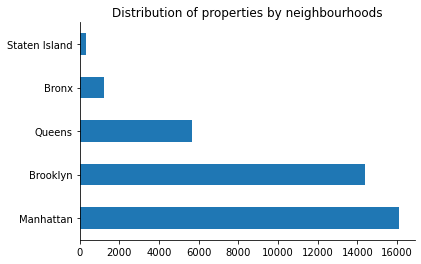

In [44]:
# total number of listigns by neighbourhoods
df["neighbourhood_group_cleansed"].value_counts().plot(kind="barh")
plt.title("Distribution of properties by neighbourhoods")
sns.despine()
plt.show()

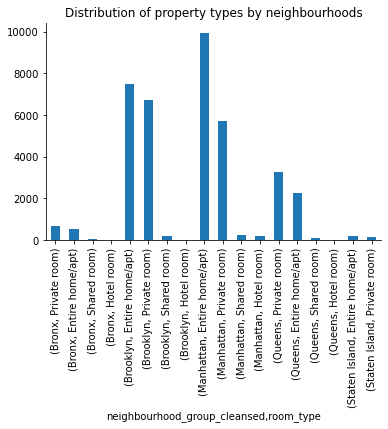

In [45]:
# number of property types by neighbourhoods
df.groupby(["neighbourhood_group_cleansed"])["room_type"].value_counts().plot(kind='bar')
plt.title("Distribution of property types by neighbourhoods")
sns.despine()
plt.show()

**Observations**
- as Manhattan has the largest representation in the dataset, the statistical difference is not obvious for each group.
- we need some categorical test (chi2) to understand if the categorical variables are independent or not.

---

**Chi2** test

In [46]:
"""
let's create a crosstab for the neighbourhoods and room types and calculate contingency, 
if the evidence of one is contingent on another or not.

"""

from scipy.stats import chi2_contingency 

chisqt = pd.crosstab(df['neighbourhood_group_cleansed'], df['room_type'], margins=True)
value = np.array([chisqt.iloc[0][0:5].values,
                  chisqt.iloc[1][0:5].values])
print(chi2_contingency(value)[0:3])

(49.82715693160533, 3.9237175561333976e-10, 4)


From above, 3.9-10 is the p-value, 49.8 is the statistical value and 4 is the degree of freedom (5 neigh_groups-1). As the p-value is far smaller than 0.05, we reject null hypothesis  as the distribution of the property type and neigbourhoods have some kind of dependence.

In [47]:
df.groupby(['neighbourhood_group_cleansed'])['room_type'].count()

neighbourhood_group_cleansed
Bronx             1203
Brooklyn         14367
Manhattan        16086
Queens            5640
Staten Island      335
Name: room_type, dtype: int64

In [48]:
entire=df[df['room_type']=='Entire home/apt']

In [49]:
entire.groupby(['neighbourhood_group_cleansed'])["id"].count()/df.groupby(['neighbourhood_group_cleansed']).count()['id']

neighbourhood_group_cleansed
Bronx            0.427265
Brooklyn         0.520081
Manhattan        0.617431
Queens           0.397518
Staten Island    0.602985
Name: id, dtype: float64

In [50]:
private=entire=df[df['room_type']=='Private room']

In [51]:
private.groupby(['neighbourhood_group_cleansed'])["id"].count()/df.groupby(['neighbourhood_group_cleansed']).count()['id']

neighbourhood_group_cleansed
Bronx            0.544472
Brooklyn         0.466416
Manhattan        0.356086
Queens           0.582092
Staten Island    0.397015
Name: id, dtype: float64

**Observations**
- Manhattan lists 48% of all Entire home/apt property type.
- Compared to all listings a neighbourhood has, Manhattan and Staten Island have the highest % in their listings being Entire home/apt
- Others have larger proportion of private rooms
- Hotel rooms and shared rooms comprise very small portion of listings in all locations

---

## Super hosts versus others analysis

We use number of reviews, number of available days as the proxy for the demand for a property. We also can use review scores as the tool to measure the success of the host. Using those measures, let's see if superhosts are significantly different than others.

In [22]:
#create subsets of data dataset based on superhost or not
"""
These subsets will be used in for Superhost versus features analysis to identify statistically 
significant differences in variables based on two groups and decide on final features.

For continues values use t-test to compare super vs non-super hosts
For categorical use chi2 test
"""
super_data=data[data['host_is_superhost']==1]
not_super_data = data[data['host_is_superhost']==0]

### Number of Reviews and Superhosts

Let's see the average number of reviews for superhosts and non-super hosts

In [23]:
# group superhosts and non, find total number of reviews, divide by the group size
df.groupby(['host_is_superhost'])['number_of_reviews'].sum()/df['host_is_superhost'].value_counts()

host_is_superhost
f    16.830822
t    54.681504
dtype: float64

In [24]:
# compare average number of reviews
55/17*100

323.5294117647059

Super hosts get 3 times more reviews (thus, rented more as one customer gives one review) than the others.

In [25]:
#use subset without extreme values to see the distribution of the reviews by host type
subset=df[df['number_of_reviews']<50]

In [26]:
superhosts=df[df['host_is_superhost']=='t']
nonsuperhosts=df[df['host_is_superhost']=='f']

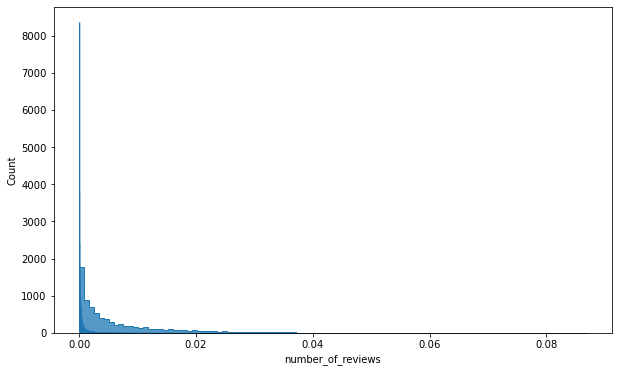

In [27]:
plt.figure(figsize=(10,6))
sns.histplot( data=superhosts, x=superhosts['number_of_reviews']/len(superhosts), element="step", palette='blue')
sns.histplot( data=nonsuperhosts, x=nonsuperhosts['number_of_reviews']/len(nonsuperhosts), element="step", palette='red');

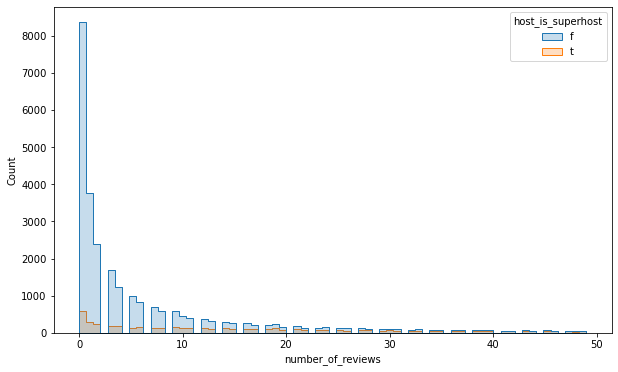

In [28]:
# sub_15=data[data['price'] < 500]
plt.figure(figsize=(10,6))
sns.histplot( data= subset, x="number_of_reviews", hue="host_is_superhost", element="step");

Let's see the t-test for two unpaired two tailed test

In [29]:
#create datasets for two groups: number of reviews super hosts and others
nofr_superh=super_data['number_of_reviews']
nofr_nonsuperh=not_super_data['number_of_reviews']

# we can use the built in function: ttest_ind
two_sample_test = stats.ttest_ind(nofr_superh, nofr_nonsuperh)

print(two_sample_test)

Ttest_indResult(statistic=58.928565211875565, pvalue=0.0)


Two sets of number of reviews ar statistically significantly different.

---

### Amenities and Superhosts

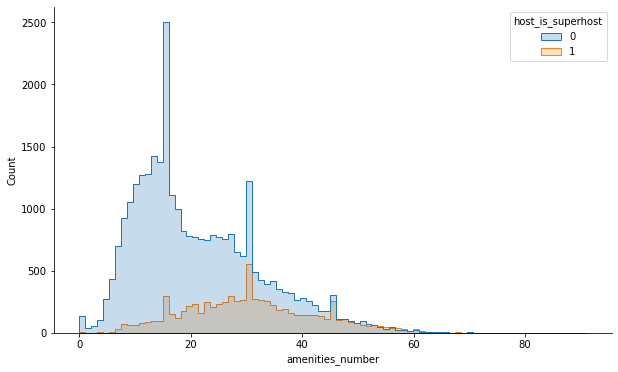

In [30]:
# superhosts and number of amenities
plt.figure(figsize=(10,6))
sns.histplot( data= data, x="amenities_number", hue="host_is_superhost", element="step")
sns.despine();

In [31]:
#create datasets for two groups: amenities super hosts and others
amenities_superh=super_data['amenities_number']
amenities_nonsuperh=not_super_data['amenities_number']

# we can use the built in function: ttest_ind
two_sample_test = stats.ttest_ind(amenities_superh, amenities_nonsuperh) 

print(two_sample_test)

Ttest_indResult(statistic=67.05229408158121, pvalue=0.0)


We can reject null hypothesis that amenities for superhosts and non-superhosts are the same. There is a statistically significant difference in the number of amenities for two groups.

In [32]:
super_mean = np.mean(super_data['amenities_number']) 
not_super_mean = np.mean(not_super_data['amenities_number'])
print(f'Store 1 (Superhosts amenities length) Mean: {super_mean}')
print(f'Store 2 (Others amenities lenght) Mean: {not_super_mean}')

Store 1 (Superhosts amenities length) Mean: 30.920667522464697
Store 2 (Others amenities lenght) Mean: 21.146579036063365


Mean difference for the superhost amenities and others is 21

---

### Review scores and Superhosts

In [ ]:
# superhosts and review scores
plt.figure(figsize=(10,6))
sns.histplot( data=super_data, x=, element="step", palette='blue')
sns.histplot( data=not_super_data, x=, element="step", palette='red');

In [75]:
data.head(1)

,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,host_months,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Hotel room,Private room,Shared room,amenities_number,wifi,tv,hot water,air conditioning,bathtub,dedicated workspace,board games,sound system,bbq grill,refrigerator
0,0,1,1,40.75356,-73.98559,1,1.0,1.0,1.0,150.0,30,1125,1,30,60,77,334,48,0,0,4.7,4.72,4.62,4.76,4.79,4.86,4.41,0,3,166.0,0,0,1,0,0,1,0,0,0,31,1,1,1,1,1,1,0,0,0,1


In [91]:
data_reviews = data[['host_is_superhost','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]

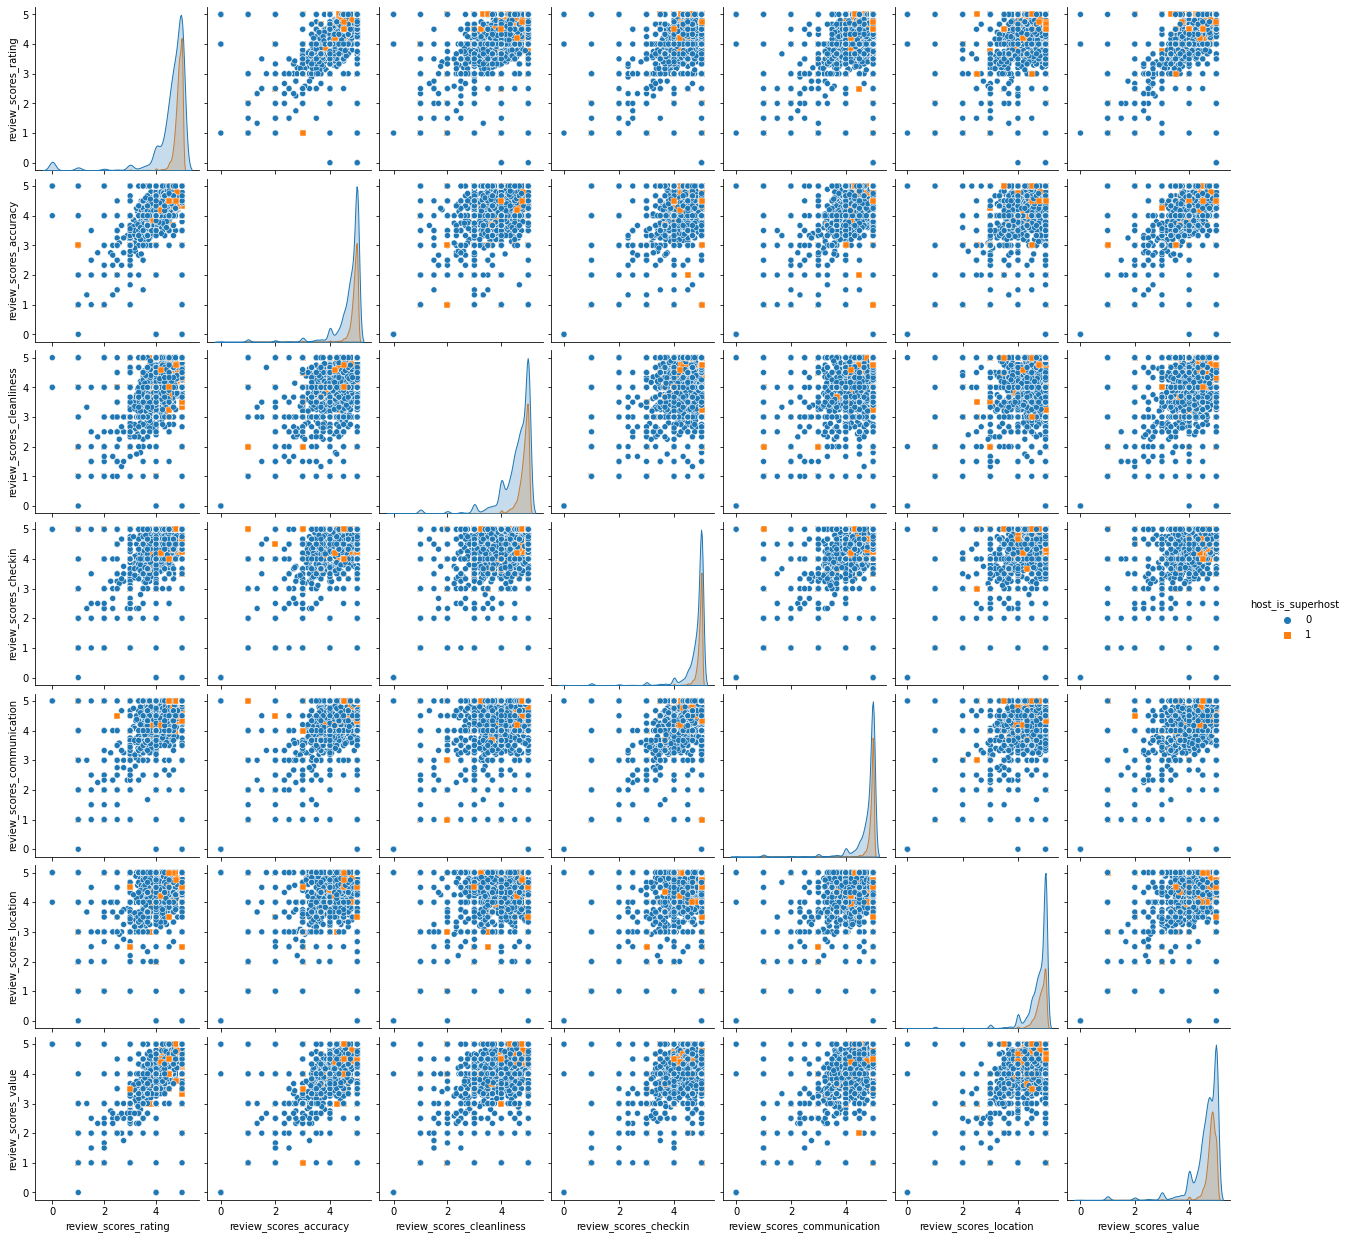

In [92]:
sns.pairplot(data_reviews, hue="host_is_superhost", markers=["o", "s"])

There are no obvious classes of reviews based on the hsot type. Let's check t-test for mean difference.

In [94]:
#create datasets for two groups: amenities super hosts and others
review_scores_superh=super_data['review_scores_rating'].dropna()
review_scores_nonsuperh=not_super_data['review_scores_rating'].dropna()

# we can use the built in function: ttest_ind
two_sample_test = stats.ttest_ind(review_scores_superh, review_scores_nonsuperh) 

print(two_sample_test)

Ttest_indResult(statistic=31.4925139710562, pvalue=5.028844234073298e-214)


In [177]:
super_mean_rating = np.mean(super_data['review_scores_rating']) 
not_super_mean_rating = np.mean(not_super_data['review_scores_rating'])
print(f'Store 1 (Superhosts amenities length) Mean: {super_mean_rating}')
print(f'Store 2 (Others amenities lenght) Mean: {not_super_mean_rating}')

Store 1 (Superhosts amenities length) Mean: 4.853380846941572
Store 2 (Others amenities lenght) Mean: 4.522105928631656


**Observations**
- We reject null hypothesis for the review_scores_rating, and can say that it is significantly different for superhosts versus not superhosts.
- Mean difference is small; 0.3, however, distributions seem different as per the t-test.

---

###  Host_months and Superhosts
- relation of the superhosts to the lengh of them being active on the platform

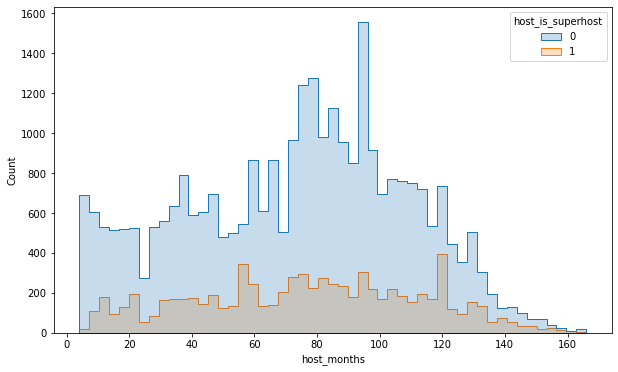

In [97]:
# superhosts and host_months
plt.figure(figsize=(10,6))
sns.histplot( data= data, x="host_months", hue="host_is_superhost", element="step");

In [98]:
#create datasets for two groups: amenities super hosts and others
months_superh=super_data['host_months']
months_nonsuperh=not_super_data['host_months']

# we can use the built in function: ttest_ind
two_sample_test = stats.ttest_ind(months_superh, months_nonsuperh) 

print(two_sample_test)

Ttest_indResult(statistic=8.030583847546554, pvalue=9.982243751384406e-16)


No statistically significant difference between operation period of a host and being a superhost.

---

### Price and Superhosts

In [88]:
data.shape

(37460, 50)

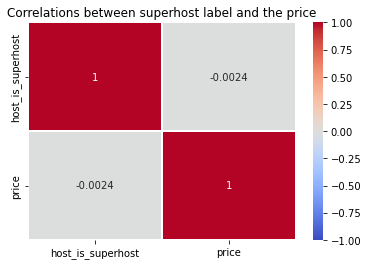

In [138]:
plt.figure(figsize = (6,4))
sns.heatmap(data[['host_is_superhost','price']].corr(), vmin=-1, vmax=1, cmap="coolwarm", annot=True, linewidths=1.5)
plt.title("Correlations between superhost label and the price")
plt.show()

In [ ]:
from scipy import stats

In [18]:
stats.pointbiserialr(data['host_is_superhost'],data['price']) 

PointbiserialrResult(correlation=-0.0023808911136492753, pvalue=0.6449443299163068)

 There is no significant difference in price for the superhost and others

---

## EDA Conclusion

**Main observations for Price**:
- price is not linearly related to any of the variables
- price is mostly related to the location, size of the property, type of the property, amenities.
- independent variables dont have multicollinearity; however, for dummie classes one class can be dropped as a reference before modelling.
- might exclude review scores as it has close to zero correlation with the price


**Main observations for Superhost**:
- Is not related to price or being longer time in market
- Superhosts tend to have more amenities, more number of reviews, higher review scores